In [1]:
from pandas import read_csv
from snrei.scripts.plot.utils import COLORS

# Loads dataframes.
load_signal_trends = read_csv(filepath_or_buffer="data/results/tables/harmonic_load_signal_trends.csv")
Love_numbers_table = read_csv(filepath_or_buffer="data/results/tables/Love_numbers.csv")

# Formats the dataframe.
load_signal_trends["asthenosphere_viscosity"] = [model_name.split("__")[-1] for model_name in load_signal_trends["long_term_anelasticity_model"]]
load_signal_trends["low_viscosity_asthenosphere"] = [
    asthenosphere_viscosity == "3e+19" for asthenosphere_viscosity in load_signal_trends["asthenosphere_viscosity"]
]
load_signal_trends["viscosity_profile"] = [model_name.split("/")[0] for model_name in load_signal_trends["long_term_anelasticity_model"]]
load_signal_trends["mu_asymptotic_ratio"] = [model_name.split("__")[-1] for model_name in load_signal_trends["short_term_anelasticity_model"]]
load_signal_trends["Q_profile"] = [model_name.split("/")[0].split("_")[-1] for model_name in load_signal_trends["short_term_anelasticity_model"]]

variability_factors = [
    "load_spatial_behaviour_file",
    "opposite_load_on_continents",
    "LIA",
    "mu_asymptotic_ratio",
    "low_viscosity_asthenosphere",
    "load_history_case",
    "viscosity_profile",
    "Q_profile",
]
option_names = ["use_long_term_anelasticity", "use_short_term_anelasticity"]

# Defines colors for each anelasticity option.
anelasticity_options = ["elastic", "long-term", "short-term", "short-term and long-term"]
colors = {anelasticity_option: COLORS[index] for anelasticity_option, index in zip(anelasticity_options, range(11, 15))}
x_positions = range(len(anelasticity_options))

results = {option: {} for option in anelasticity_options}
# Loops on
for parameter in variability_factors:

    # Gets the data grouped by value of the selected parameter.
    for option_name in option_names:
        Love_numbers_id_condition = Love_numbers_table["ID"][Love_numbers_table[option_name]].values
        load_signal_trends[option_name] = [id in Love_numbers_id_condition for id in load_signal_trends["Love_numbers_ID"].values]
    grouped_df = (
        load_signal_trends.groupby(option_names + [parameter_value for parameter_value in variability_factors if parameter_value != parameter])[
            "ocean_mean_step_3"
        ]
        .aggregate(["std"])
        .groupby(option_names)
        .aggregate("max") # TODO: mean instead? Not sure.
    )
    results[anelasticity_options[0]][parameter] = grouped_df.loc[False, False]["std"]
    results[anelasticity_options[1]][parameter] = grouped_df.loc[True, False]["std"]
    results[anelasticity_options[2]][parameter] = grouped_df.loc[False, True]["std"]
    results[anelasticity_options[3]][parameter] = grouped_df.loc[True, True]["std"]

/home/maxime/miniconda3/envs/venv/lib/python3.12/site-packages/pymssa/mssa.py:10: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
from matplotlib.pyplot import scatter, legend, figure, grid, xticks
from numpy import argsort

figure(figsize=(10, 6))
sort_indices = argsort(list(results["short-term and long-term"].values()))
sorted_variability_factors = variability_factors[sort_indices]
for option in anelasticity_options:
    scatter(results[option].keys(), results[option].values(), label=option)
legend()
xticks(rotation=45)
grid()

TypeError: only integer scalar arrays can be converted to a scalar index

<Figure size 1000x600 with 0 Axes>

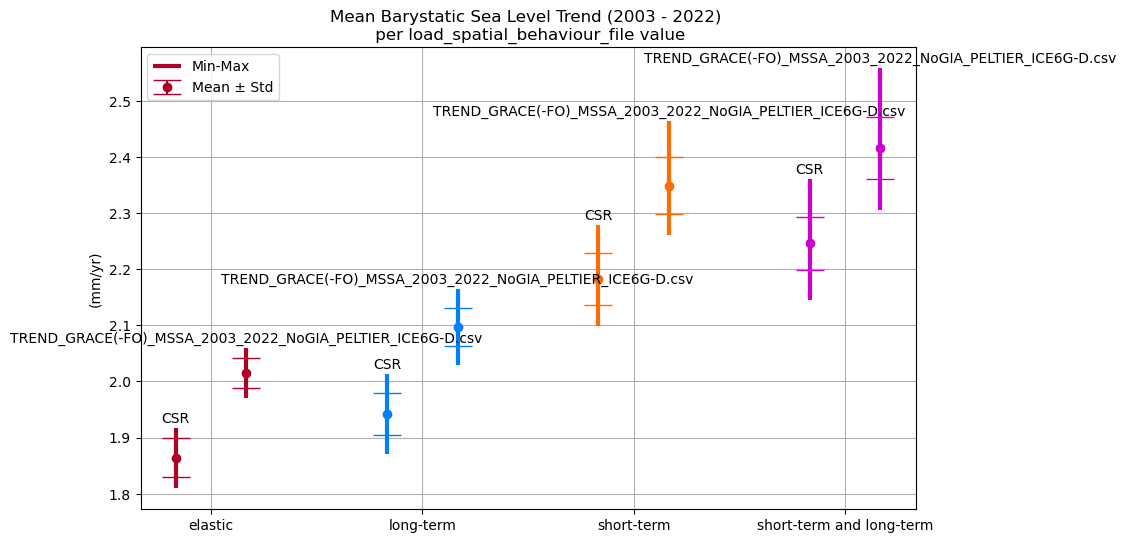

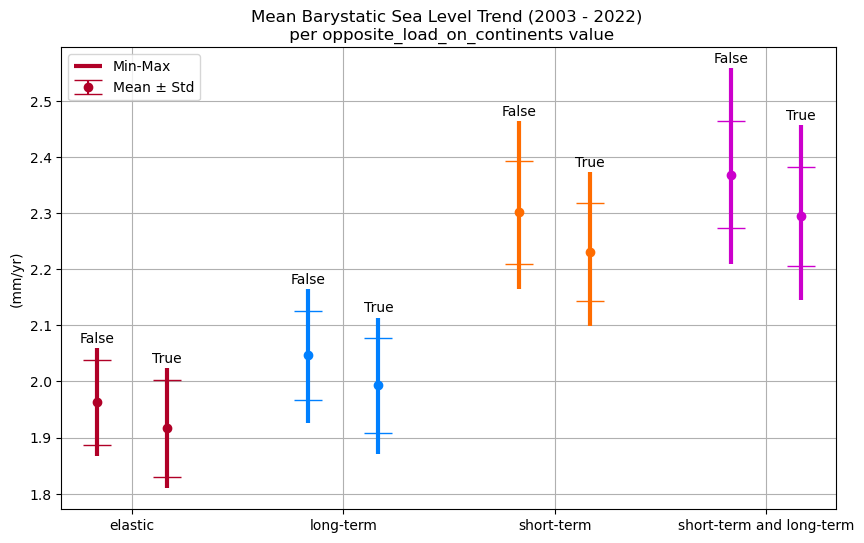

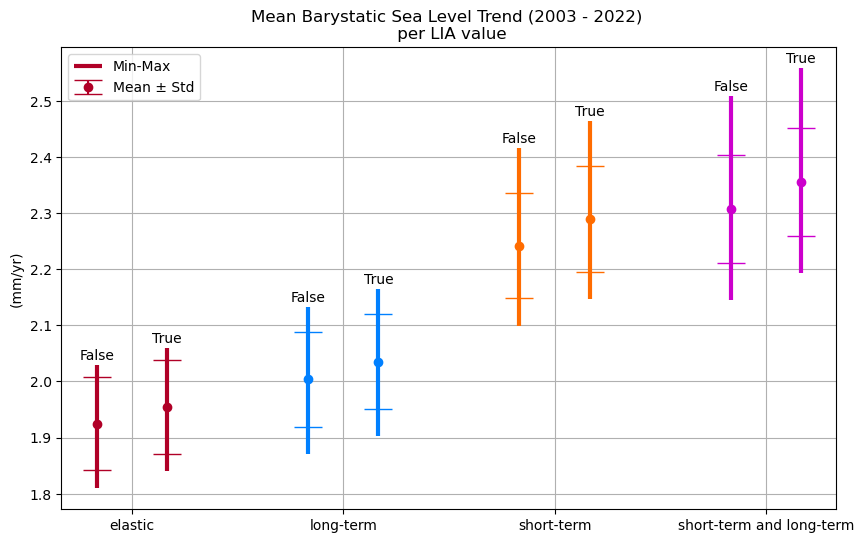

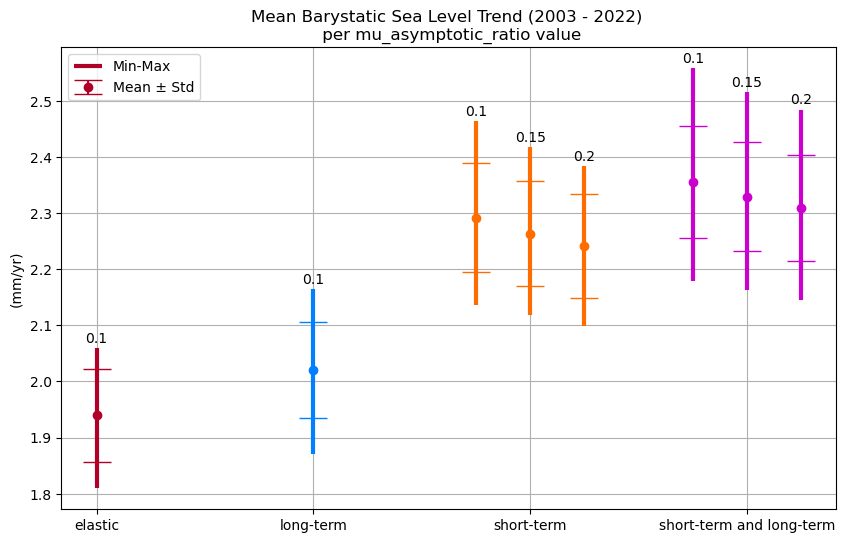

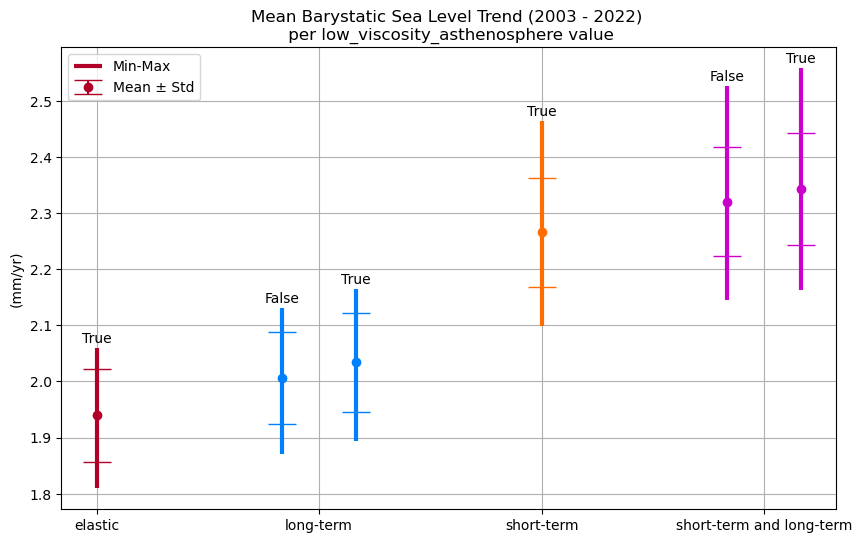

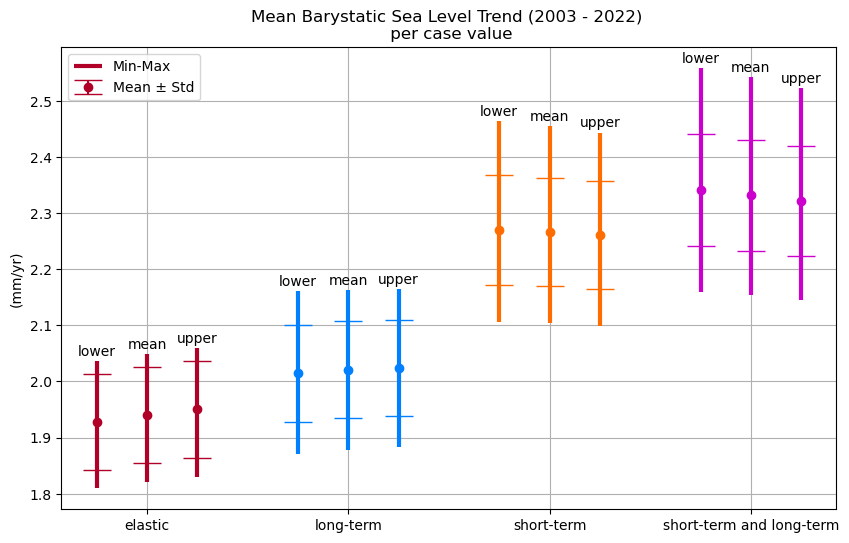

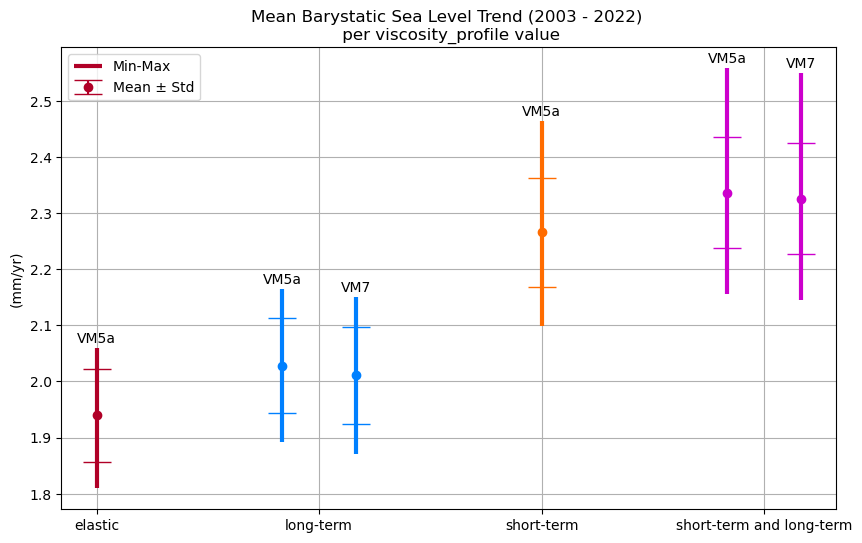

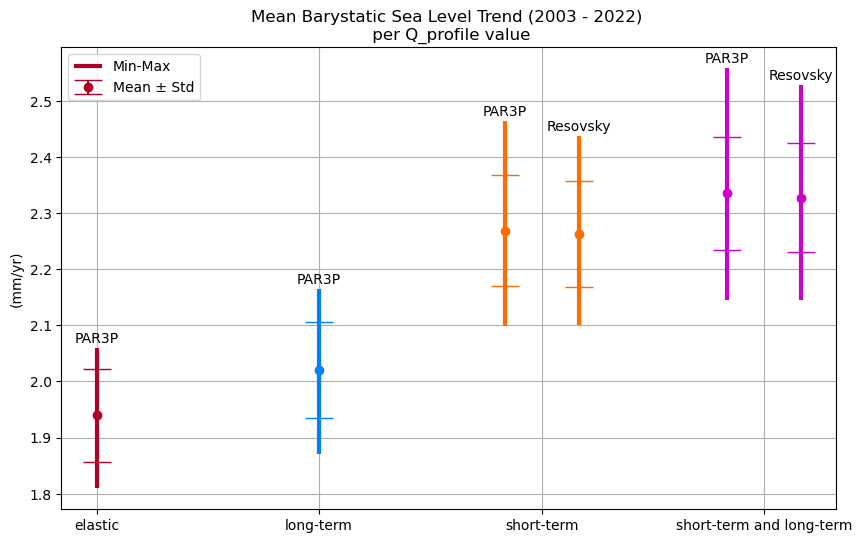

In [3]:
from matplotlib.pyplot import figure, errorbar, vlines, show, grid, title, ylabel, xticks, legend, text
from numpy import linspace

# Loops on figures to produce.
for parameter in sorted_variability_factors:

    # Gets the data grouped by value of the selected parameter.
    for option_name in option_names:
        Love_numbers_id_condition = Love_numbers_table["ID"][Love_numbers_table[option_name]].values
        load_signal_trends[option_name] = [id in Love_numbers_id_condition for id in load_signal_trends["Love_numbers_ID"].values]
    grouped_df = load_signal_trends.groupby(option_names + [parameter])["ocean_mean_step_3"].aggregate(["mean", "std", "max", "min"])
    grouped_df["Anelasticity"] = [
        "short-term and long-term" if short_term and long_term else ("short-term" if short_term else ("long-term" if long_term else "elastic"))
        for long_term, short_term, _ in grouped_df.index.values
    ]

    # Sorts.
    grouped_df = grouped_df.sort_values(by="Anelasticity")

    # Creates a single figure for all groups.
    figure(figsize=(10, 6))

    # Tracks already used labels to prevent duplication in the legend.
    used_labels = set()

    # Iterates over colors for anelasticity options.
    for (anelasticity_option, color), x_position in zip(colors.items(), x_positions):

        sub_group = grouped_df[grouped_df["Anelasticity"] == anelasticity_option]
        parameter_values = [parameter for _, _, parameter in sub_group.index]
        offsets = {
            key: offset_value for key, offset_value in zip(parameter_values, linspace(start=-0.5, stop=0.5, num=len(parameter_values) + 2)[1:-1])
        }

        # Iterates over the groups and plot them on the same figure.
        for value in parameter_values:

            data = sub_group[[parameter == value for parameter in parameter_values]].iloc[0]

            x_value = x_position + offsets[value]  # Adjusting x-value by offset for side-by-side plotting.

            # Plots mean ± std error bars.
            errorbar(
                x=x_value,
                y=data["mean"],
                yerr=data["std"],
                fmt="o",
                capsize=10,
                color=color,
                label="Mean ± Std" if "Mean ± Std" not in used_labels else "",
            )

            # Plots min-max as vertical lines.
            vlines(x=x_value, ymin=data["min"], ymax=data["max"], colors=color, lw=3, label="Min-Max" if "Min-Max" not in used_labels else "")

            # Adds labels to track and avoid duplicates in the legend.
            used_labels.add("Mean ± Std")
            used_labels.add("Min-Max")

            # Adds the "value" text below each error bar.
            text(x_value, data["max"] + 0.01, str(value), ha="center", fontsize=10)

    # Adds labels and a legend.
    ylabel("(mm/yr)")
    xticks(x_positions, colors.keys())  # Custom x-labels for each category
    legend()
    grid()
    title("Mean Barystatic Sea Level Trend (2003 - 2022) \n per " + str(parameter) + " value")
    show()